In [1]:
pwd()

"/home/xlx0727/Scripts/Statistic/qgplsim"

# Start

In [2]:
# run this ceil if source codes was edited
include("DGP.ji")
# include("qgplsim.ji")
include("MonteCarloSIM.ji")
using Statistics, LinearAlgebra, Clustering
using LaTeXStrings, Plots

import Base.Threads.@threads

# QGPLSIM fitting

In [4]:
# run this ceil for different data sets

α = [1.0, 2.0] # single index for x
θ = [2.0, -1.0]  # linear for x, <α, θ> = 0 for identification
γ = [0.5, 1.0] # single index for z
β = [-1.0, -0.5] # linear for z
# Q(y|x, z) = Xθ + Zβ + g(Xα + Zγ)

n = 300
fx = 2 # y = f(x), fx for different f(x)     
                # fx = 1, y = X*θ + Z*β + (X*α + Z*γ .- 1).^2 + 0.2ϵ
                # fx = 2, y = X*θ + Z*β + log.(1 .+ exp.(X*α + Z*γ .- 1)) + 0.2ϵ

ifz = true # if false, Z = 0, i.e. no category varible
dist = 1 # 0 for gauss, 1 for Cauchy
X, Z, y = dgp(n, γ, θ, α, β, fx, dist,  ifz)
# p = length(α)
# q = length(γ)
τ = 0.5

# Estimation 

model1 = qgplsim.model(X, Z, y, τ)
alpha_type = 1
# different weight of sum on alpha 
# 0 for true alpha, using α in DGP
# 1 for global: ∑ij sum(Bi - Bj) / n;
# 2 for local: ∑z ∑ij (bzi - bzj) * nz / n;
# when Z = 0, global == local
@time alpha1, gamma, theta, beta, squ = qgplsim.estimator(model1, alpha_type)
coefa = 1 #/ alpha[1]
coefg = 1 #/ gamma[1]
println("Estimation of index coefs: ")
println("̂α => ", coefa * alpha1)
println("̂γ => ", gamma)

println("Estimation of linear coefs: ")
println("̂θ => ", theta)
println("̂β => ", beta)

println("square of integral: ", squ)

# theta * alpha

c1 and c0: 1.6126568533071874 1.473834414303704 v1 - v0: 3.0020390529437684
  1.229828 seconds (1.69 M allocations: 2.924 GiB, 22.89% gc time)
Estimation of index coefs: 
̂α => [0.41723711159617993; 0.9087976632380153]
̂γ => [0.2433089665719598, 0.46051530896729553]
Estimation of linear coefs: 
̂θ => [2.0632254916763717 -0.9472452224970115]
̂β => [-0.47370025858638415, -0.6564643314967579]
square of integral: 0.4167503833133612


# Paths of $g(x \alpha + z \gamma)$ and $\nabla g$

$\alpha = \hat{\alpha}$,
$z \in S_z$

In [5]:
model1.index

Dict{Vector{Float64}, Vector{Int64}} with 6 entries:
  [0.0, 1.0] => [1, 14, 15, 16, 30, 33, 34, 37, 40, 43  …  274, 275, 277, 281, …
  [1.0, 0.0] => [21, 28, 31, 47, 68, 70, 79, 80, 86, 108  …  202, 213, 216, 222…
  [1.0, 2.0] => [4, 7, 8, 19, 22, 26, 35, 49, 58, 61  …  206, 209, 234, 240, 25…
  [0.0, 2.0] => [3, 6, 17, 29, 36, 44, 48, 50, 59, 63  …  219, 227, 228, 231, 2…
  [1.0, 1.0] => [2, 5, 9, 12, 13, 18, 20, 23, 25, 27  …  268, 272, 273, 280, 28…
  [0.0, 0.0] => [10, 11, 24, 42, 45, 52, 53, 55, 56, 64  …  201, 210, 218, 230,…

In [6]:
g = zeros(n)
dg = zeros(n)
v = X * alpha1 
yz = y - X * transpose(theta)
categ, index = model1.categ, model1.index
z = collect(index)
ncateg = index.count
width = zeros(ncateg)
v0 = -1e6
v1 = 1e6

for k in 1:ncateg
    vk = v[z[k][2]]
    h = (length(vk))^(-0.17) * var(vk)
    width[k] = h

    dgk(u) = qgplsim.Gz(u, vk, yz[z[k][2]], 1, τ)
    gk(u) = qgplsim.Gz(u, vk, yz[z[k][2]], 0, τ)

    dg[z[k][2]] = dgk(vk)
    g[z[k][2]] = gk(vk)

    vkmin = minimum(vk) + h
    vkmax = maximum(vk) - h

    if  vkmin > v0
        v0 = vkmin
    end
    if  vkmax < v1
        v1 = vkmax
    end  
end

# g, dg = qgplsim.G(v, Z, yz, τ, -0.4) # g: g(v), dg: g'(v)

println(width)
# v0, v1 = v0 + h, v1 - h
v0, v1

[1.6127161207968495, 1.7660218478617022, 2.437677847778071, 1.5955132140514414, 1.7243049932052377, 1.5553399097927578]


(-1.591509173272576, 1.4105298796711923)

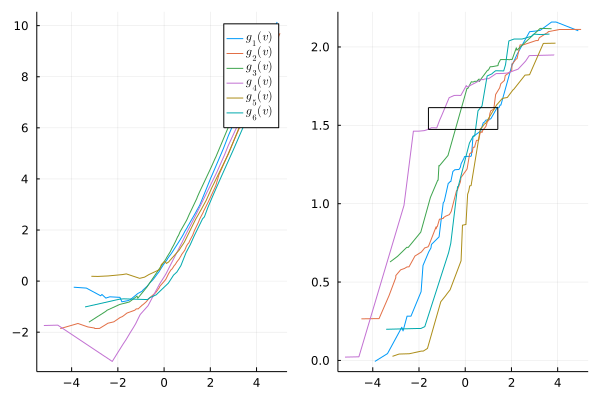

In [7]:
C0 = zeros(ncateg)
C1 = zeros(ncateg)
dgf(vv, k) = qgplsim.Gz(vv, v[z[k][2]], yz[z[k][2]], 1, τ)


p1 = plot()
p2 = plot()
for m in 1:ncateg
    C0[m] = dgf(v0, m)[1]
    C1[m] = dgf(v1, m)[1]

    vm = v[index[categ[m]]]
    dgm = dg[index[categ[m]]]
    gm = g[index[categ[m]]]
    indm = sortperm(vm)
    sorted_dgm = dgm[indm]
    sorted_gm = gm[indm]
    sorted_vm = vm[indm]
    plot!(p1, sorted_vm, sorted_gm, label = L"g_{%$m} (v)")
    plot!(p2, sorted_vm, sorted_dgm, label = false )# L"\nabla g_{%$m} (v)")

end

c0 = maximum(C0)
c1 = minimum(C1)
plot!(p2, [v0, v0], [c0, c1], color = "black", label = false)
plot!(p2, [v1, v1], [c0, c1], color = "black", label = false)
plot!(p2, [v0, v1], [c0, c0], color = "black", label = false)
plot!(p2, [v0, v1], [c1, c1], color = "black", label = false)


plot(p1, p2, layout = (1,2))

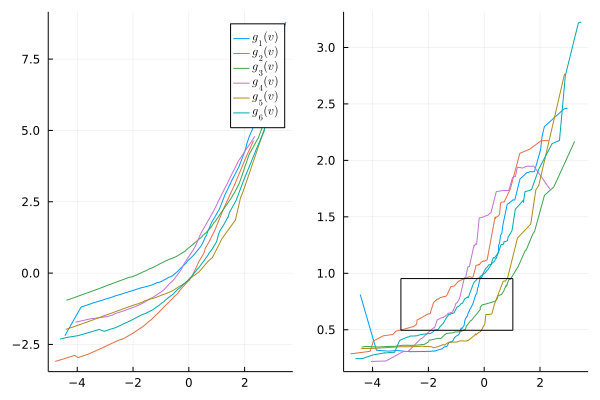

In [53]:
C0 = zeros(ncateg)
C1 = zeros(ncateg)
dgf(vv, k) = qgplsim.Gz(vv, v[z[k][2]], yz[z[k][2]], 1, τ)


p1 = plot()
p2 = plot()
for m in 1:ncateg
    C0[m] = dgf(v0, m)[1]
    C1[m] = dgf(v1, m)[1]

    vm = v[index[categ[m]]]
    dgm = dg[index[categ[m]]]
    gm = g[index[categ[m]]]
    indm = sortperm(vm)
    sorted_dgm = dgm[indm]
    sorted_gm = gm[indm]
    sorted_vm = vm[indm]
    plot!(p1, sorted_vm, sorted_gm, label = L"g_{%$m} (v)")
    plot!(p2, sorted_vm, sorted_dgm, label = false )# L"\nabla g_{%$m} (v)")

end

c0 = maximum(C0)
c1 = minimum(C1)
plot!(p2, [v0, v0], [c0, c1], color = "black", label = false)
plot!(p2, [v1, v1], [c0, c1], color = "black", label = false)
plot!(p2, [v0, v1], [c0, c0], color = "black", label = false)
plot!(p2, [v0, v1], [c1, c1], color = "black", label = false)


plot(p1, p2, layout = (1,2))

In [79]:
[C0 C1]

6×2 Matrix{Float64}:
 0.468544  1.43035
 0.464025  1.78102
 0.874062  1.93499
 1.21755   2.08242
 0.928761  1.96797
 0.781526  1.62276

# Monte Carlo Simulation

In [8]:
Threads.nthreads()

4

In [9]:
include("MonteCarloSIM.ji")

main (generic function with 4 methods)

In [56]:
α = [1.0, -2.0] # single index for x
θ = [2.0, 1.0]  # linear for x, <α, θ> = 0 for identification
γ = [0.5, 1.0] # single index for z
β = [-0.5, -0.5] # linear for z
τ = 0.5
# Q(y|x, z) = Xθ + Zβ + g(Xα + Zγ)
n = 600
fx = 1
dist = 1 # Cauchy
rep = 200 # MC rept. times

50

In [54]:
Alpha, Gamma, Theta, Beta, Squ = MonteCarlo(n, γ, θ, α, β, τ, fx, dist, rep)

c1 and c0: 1.7000991167895954 0.6533039421813192 v1 - v0: 4.199701802134309
c1 and c0: 1.9608503774614001 1.250599918415568 v1 - v0: 3.4882463121960594
c1 and c0: 1.950340944308593 1.2741590316166471 v1 - v0: 3.8334211875115223
c1 and c0: 0.8190518553473404 0.3429446620095714 v1 - v0: 3.2098821237607367
c1 and c0: 2.311029559028105 1.5233977045346787 v1 - v0: 4.424358360503233
c1 and c0: 2.0176967199314046 1.0148891085799912 v1 - v0: 3.9090241078657257
c1 and c0: 1.349405381831568 0.7578739975768175 v1 - v0: 3.362573643415732
c1 and c0: 1.2375790706684409 0.8100211526815838 v1 - v0: 3.3111217792378995
c1 and c0: 1.798269466304896 0.4755460488267948 v1 - v0: 4.068547470895156
c1 and c0: 1.5734053101248526 0.2899269750760234 v1 - v0: 4.527508448607209
c1 and c0: 1.6362186920869928 0.8684128046247531 v1 - v0: 3.563662984097586
c1 and c0: 2.0020813611643957 1.5433027496928424 v1 - v0: 3.7025141329293634
c1 and c0: 2.0776468693109447 1.6208442764281203 v1 - v0: 4.257990753384324
c1 and c0: 

([0.5450108544250363 -0.8384289883817783; 0.4754494256060523 -0.8797430554945431; … ; 0.1743014292068846 -0.9846923437177917; 0.37875890427648395 -0.9254953767746641], [0.1898495944288888 0.37569558676112136; 0.12801779348582423 0.43061116405471944; … ; 0.21401492537164937 0.4276948629922746; 0.13437663964500016 0.41738756261509485], [1.7915481392276482 1.1645746934258374; 1.9267837991766161 1.041313420849449; … ; 2.5329883761334715 0.44836694114788705; 2.2004551023987955 0.9005360636145989], [-0.2558081573437372 -0.3155478250969202; -0.1569043471086267 -0.2426447615305917; … ; -0.3860429619804167 0.07357461141097968; -0.2556881809742735 -0.2304866226234895], [4.396227581267876, 2.477528544502182, 2.592090070725372, 1.5282479688888015, 3.4847655804266573, 3.9199991283239184, 1.9890678419482481, 1.415696334131894, 5.3815630148743265, 5.810959005537889  …  3.6711428260161325, 3.863911439926239, 1.4019713642420035, 4.58259000989402, 4.68270802352488, 1.8361746341768823, 3.0001113376446065

In [55]:
mb = mean(Beta, dims = 1)

1×2 Matrix{Float64}:
 -0.21683  -0.195959

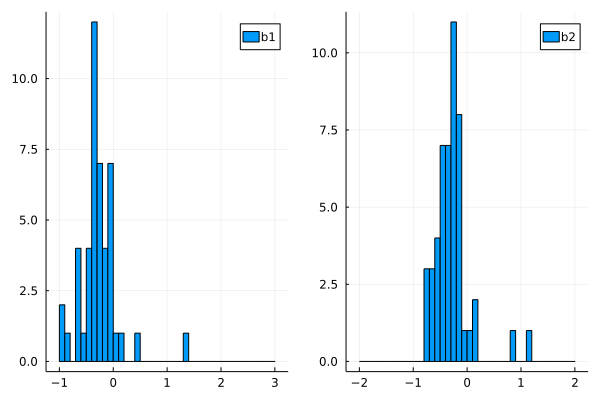

In [50]:

p1 = histogram(Beta[:,1], bins = -1:0.1:3, label = "b1")
p2 = histogram(Beta[:,2], bins = -2:0.1:2, label = "b2")
plot(p1, p2, layout = (1, 2))

In [51]:
mg = mean(Gamma, dims = 1)

1×2 Matrix{Float64}:
 0.265351  0.559529

In [52]:
median(Gamma, dims = 1)

1×2 Matrix{Float64}:
 0.273828  0.578434

In [45]:
(γ |> transpose) ./ mg

1×2 Matrix{Float64}:
 1.8843  1.78722

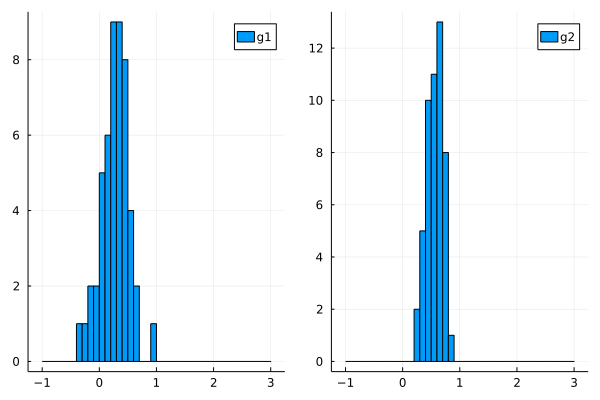

In [46]:
p1 = histogram(Gamma[:,1], bins = -1:0.1:3, label = "g1")
p2 = histogram(Gamma[:,2], bins = -1:0.1:3, label = "g2")
plot(p1, p2, layout = (1, 2))

In [47]:
ma = mean(Alpha, dims = 1)

1×2 Matrix{Float64}:
 0.466182  -0.874659

In [48]:
mt = mean(Theta, dims = 1)

1×2 Matrix{Float64}:
 1.92267  0.998404

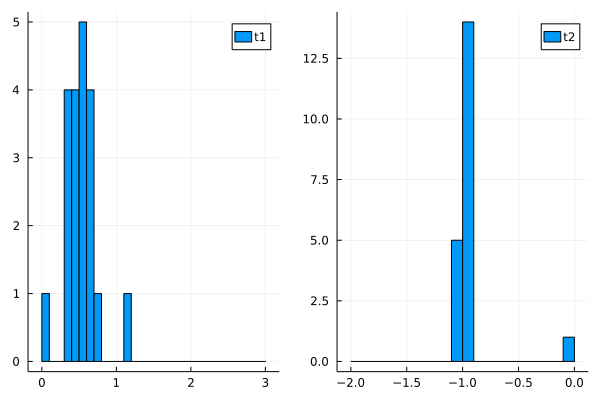

In [91]:
p1 = histogram(Theta[:,1], bins = 0:0.1:3, label = "t1")
p2 = histogram(Theta[:,2], bins = -2:0.1:-0, label = "t2")
plot(p1, p2, layout = (1, 2))

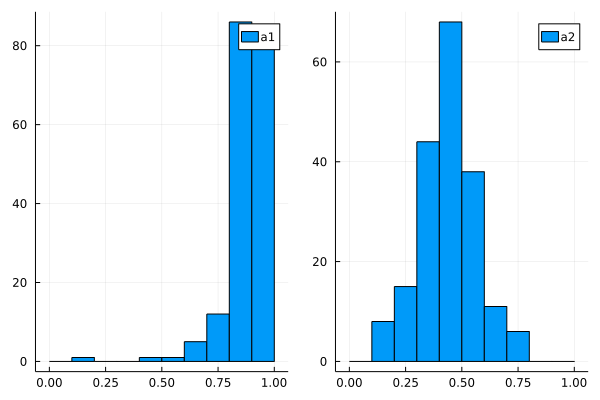

In [35]:
p1 = histogram(Alpha[:,1], bins = 0:0.1:1, label = "a1")
p2 = histogram(Alpha[:,2], bins = 0:0.1:1, label = "a2")
plot(p1, p2, layout = (1, 2))